In [ ]:
!pip install -qU bitsandbytes sentencepiece accelerate transformers

# Image Tasks with IDEFICS

**IDEFICS** is an open-source vision and language model based on Flamingo, a SOTA vision language model initially developed by DeepMind. The model accepts arbitrary sequences of image and text inputs and generates coherent text as output. It can answer questions about images, describe visual content, create stories grounded in multiple images, and so on.

## Loading the model

In [ ]:
import torch
from transformers import IdeficsForVisionText2Text, AutoProcessor

checkpoint = "HuggingFaceM4/idefics--9b"
processor = AutoProcessor.from_pretrained(checkpoint)
model = IdeficsForVisionText2Text.from_pretrained(
    checkpoint,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

### Quantized model

We can load the quantized model if our GPU does not enough RAM.

In [ ]:
import torch
from transformers import IdeficsForVisionText2Text, AutoProcessor, BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb4bit_compute__dtype=torch.float16,
)

processor = AutoProcessor.from_pretrained(checkpoint)
model = IdeficsForVisionText2Text.from_pretrained(
    checkpoint,
    quantization_config=quantization_config,
    device_map="auto"
)

## Image captioning

IDEFICS accepts text and image prompts. To caption an image, we do not have to provide a text prompt to the model. Without a text prompt, the modell will start generating text ffrom the BOS (beginning-of-sequencce) token creating a caption.

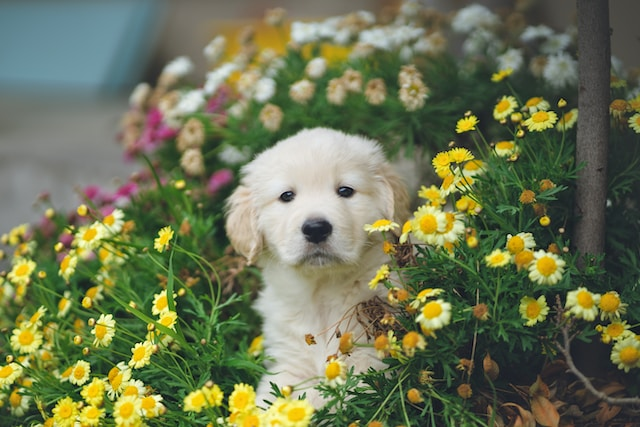

In [4]:
from PIL import Image
import requests

prompt = [
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/idefics-im-captioning.jpg"
]

image = Image.open(requests.get(prompt[0], stream=True).raw)
image

In [ ]:
inputs = processor(
    prompt,
    return_tensors="pt"
).to('cuda')

bad_words_ids = processor.tokenizer(
    ['<image>', '<fake_token_around_image>'],
    add_special_tokens=False,
).input_ids

generated_ids = model.generate(
    **inputs,
    max_new_tokens=1,
    bad_words_ids=bad_words_ids,
)
generated_text = processor.batch_decode(
    generated_ids,
    skip_special_tokens=True
)
generated_text[0]

It is a good idea to include the `bad_words_ids` in the call to `generate` to avoid errors arising when increasing the `max_new_tokens`: the model will want to generate a new `<image>` or `<fake_token_around_image>` token when there is no image being generated by the model.

## Prompted image captioning

We can extend image captioning by providing a text prompt, which the model will continue given the image.

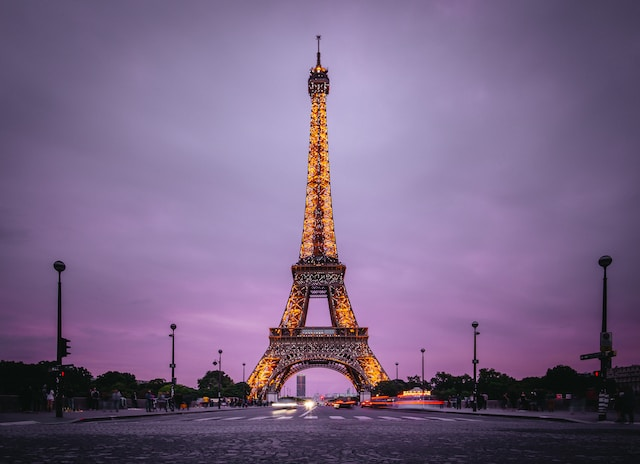

In [5]:
prompt = [
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/idefics-prompted-im-captioning.jpg",
    "This is an image of ",
]

image = Image.open(requests.get(prompt[0], stream=True).raw)
image

In [ ]:
inputs = processor(
    prompt,
    return_tensors='pt'
).to('cuda')

bad_words_ids = processor.tokenizer(
    ['<image>', '<fake_token_around_image>'],
    add_special_tokens=False,
).input_ids

generated_ids = model.generate(
    **inputs,
    max_new_tokens=10,
    bad_words_ids=bad_words_ids
)
generated_text = processor.batch_decode(
    generated_ids,
    skip_special_tokens=True
)
generated_text[0]

### Few-shot prompting

Few-shot prompting can be used to enable in-context learning. By providing examples in the prompt, we can steer the model to generate results that mimic the format of given examples.

In [7]:
prompt = ["User:",
           "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/idefics-prompted-im-captioning.jpg",
           "Describe this image.\nAssistant: An image of the Eiffel Tower at night. Fun fact: the Eiffel Tower is the same height as an 81-storey building.\n",
           "User:",
           "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/idefics-few-shot.jpg",
           "Describe this image.\nAssistant:"
           ]

images = []
for idx in [1, 4]:
    image = Image.open(requests.get(prompt[idx], stream=True).raw)
    images.append(image)

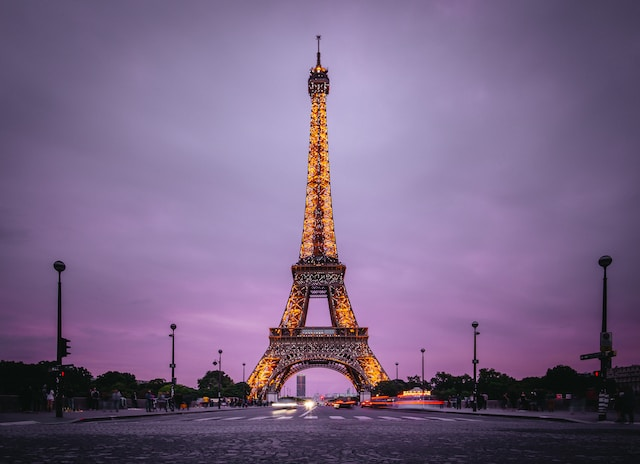

In [8]:
images[0]

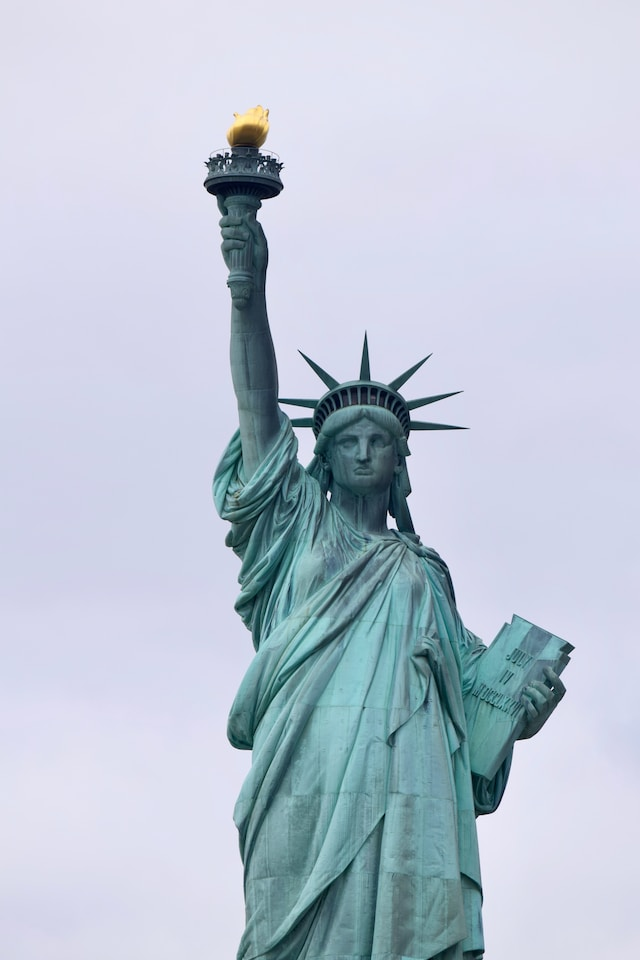

In [9]:
images[1]

In [ ]:
inputs = processor(
    prompt,
    return_tensors='pt'
).to('cuda')

bad_words_ids = processor.tokenizer(
    ['<image>', '<fake_token_around_image>'],
    add_special_tokens=False,
).input_ids

generated_ids = model.generate(
    **inputs,
    max_new_tokens=30,
    bad_words_ids=bad_words_ids
)
generated_text = processor.batch_decode(
    generated_ids,
    skip_special_tokens=True
)
generated_text[0]

By just using a single example (i.e., 1-shot) the model has learned how to perform the task..

## Visual question answering

Visual Question Answering (VQA)) is the task of answering open-ended questions based on an image.. Similar to image captioning it can be used in accessibility applications, but also in education (reasoning about visual materials), customer service (questions about products based on images), and image retrieval.

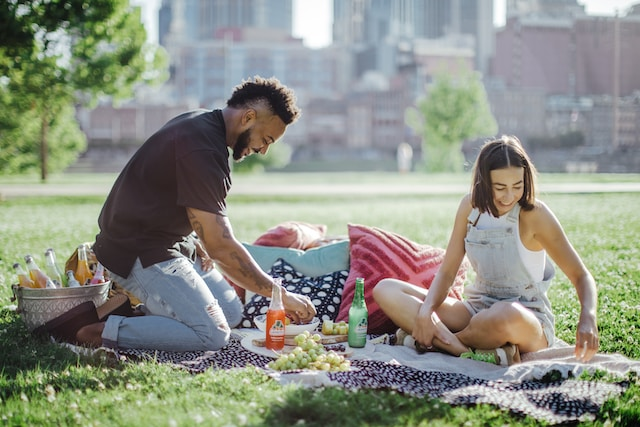

In [11]:
prompt = [
    "Instruction: Provide an answer to the question. Use the image to answer.\n",
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/idefics-vqa.jpg",
    "Question: Where are these people and what's the weather like? Answer:"
]

image = Image.open(requests.get(prompt[1], stream=True).raw)
image

In [ ]:
inputs = processor(
    prompt,
    return_tensors='pt'
).to('cuda')

bad_words_ids = processor.tokenizer(
    ['<image>', '<fake_token_around_image>'],
    add_special_tokens=False,
).input_ids

generated_ids = model.generate(
    **inputs,
    max_new_tokens=20,
    bad_words_ids=bad_words_ids
)
generated_text = processor.batch_decode(
    generated_ids,
    skip_special_tokens=True
)
generated_text[0]

## Image classification

IDEFICS is capable of classifying images into different categories without being explicitly trained on data containing labeled examples from those specific categories.

Given a list of categories and using its image and text understanding capabilities, the model can infer which category the image likel belongs to.

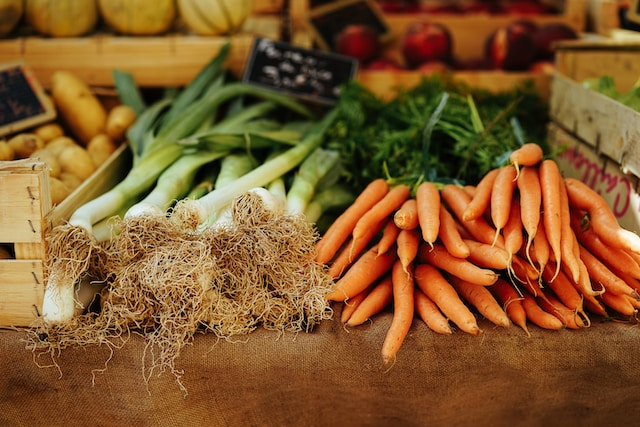

In [12]:
categories = ['animals','vegetables', 'city landscape', 'cars', 'office']
prompt = [f"Instruction: Classify the following image into a single category from the following list: {categories}.\n",
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/idefics-classification.jpg",
    "Category: "
]

image = Image.open(requests.get(prompt[1], stream=True).raw)
image

In [ ]:
inputs = processor(
    prompt,
    return_tensors='pt'
).to('cuda')

bad_words_ids = processor.tokenizer(
    ['<image>', '<fake_token_around_image>'],
    add_special_tokens=False,
).input_ids

generated_ids = model.generate(
    **inputs,
    max_new_tokens=6,
    bad_words_ids=bad_words_ids
)
generated_text = processor.batch_decode(
    generated_ids,
    skip_special_tokens=True
)
generated_text[0]

## Image-guided text generation

For more creative applications, we can use image-guided text generation to generate text based on the image. This can be useful to create description of products, ads, description of a scene, etc.

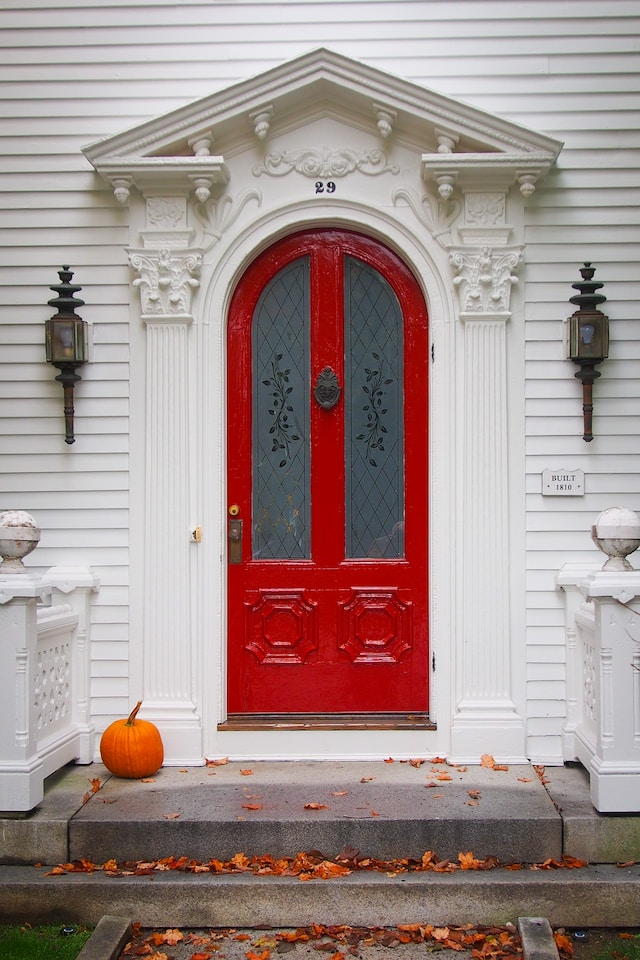

In [13]:
prompt = ["Instruction: Use the image to write a story. \n",
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/idefics-story-generation.jpg",
    "Story: \n"]

image = Image.open(requests.get(prompt[1], stream=True).raw)
image

In [ ]:
inputs = processor(
    prompt,
    return_tensors='pt'
).to('cuda')

bad_words_ids = processor.tokenizer(
    ['<image>', '<fake_token_around_image>'],
    add_special_tokens=False,
).input_ids

generated_ids = model.generate(
    **inputs,
    num_beams=2,
    max_new_tokens=200,
    bad_words_ids=bad_words_ids
)
generated_text = processor.batch_decode(
    generated_ids,
    skip_special_tokens=True
)
generated_text[0]

## Running inference in batch mode

We can run inference for a batch of examples by passing a list of prompts:

In [14]:
prompt = [
    [
        "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/idefics-prompted-im-captioning.jpg",
        "This is an image of ",
    ],
    [
        "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/idefics-few-shot.jpg",
        "This is an image of "
    ],
    [
        "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/idefics-story-generation.jpg",
        "This is an image of "
    ],
]

images = []
for batch in prompt:
    image = Image.open(requests.get(batch[0], stream=True).raw)
    images.append(image)

In [ ]:
inputs = processor(
    prompt,
    return_tensors='pt'
).to('cuda')

bad_words_ids = processor.tokenizer(
    ['<image>', '<fake_token_around_image>'],
    add_special_tokens=False,
).input_ids

generated_ids = model.generate(
    **inputs,
    max_new_tokens=10,
    bad_words_ids=bad_words_ids
)
generated_text = processor.batch_decode(
    generated_ids,
    skip_special_tokens=True
)

for idx, text in enumerate(generated_text):
    print(f"Image {idx}: {text}")

### IDEFICS instruct for conversational use

For conversationall use case, we can use `HuggingFaceM4/idefics-80b-instruct` and `HuggingFaceM4/idefics-9b-instruct`.

These checkpoints are the result of fine-tuning the respetive base models on a mixture of supervised and instruction fine-tuning datasets, which boosts the downstream performance while making the models more usable in conversational settings.

In [ ]:
import torch
from transformers import IdeficsForVisionText2Text, AutoProcessor
from accelerate.test_utils.testing import get_backend

device, _, _ = get_backend()

checkpoint = 'HuggingFaceM4/idefics-9b-instruct'
processor = AutoProcessor.from_pretrained(checkpoint)
model = IdeficsForVisionText2Text.from_pretrained(
    checkpoint,
    torch_dtype=torch.bfloat16,
).to(device)

In [ ]:
prompts = [
    [
        "User: What is in this image?",
        "https://upload.wikimedia.org/wikipedia/commons/8/86/Id%C3%A9fix.JPG",
        "<end_of_utterance>",

        "\nAssistant: This picture depicts Idefix, the dog of Obelix in Asterix and Obelix. Idefix is running on the ground.<end_of_utterance>",

        "\nUser:",
        "https://static.wikia.nocookie.net/asterix/images/2/25/R22b.gif/revision/latest?cb=20110815073052",
        "And who is that?<end_of_utterance>",

        "\nAssistant:",
    ],
]

In [ ]:
# --batched mode
inputs = processor(
    prompts,
    add_end_of_utterance_token=False,
    return_tensors='pt'
).to(device)

# --single sample mode
# inputs = processor(prompts[0], return_tensors='pt').to(device)

# Generation args
exit_condition = processor.tokenizer(
    '<end_of_utterance>',
    add_special_tokens=False,
).input_ids
bad_words_ids = processor.tokenizer(
    ['<image>', '<fake_token_around_image>'],
    add_special_tokens=False
).input_ids

generation_ids = model.generate(
    **inputs,
    eos_token_id=exit_condition,
    bad_words_ids=bad_words_ids,
    max_length=100
)
generated_text = processor.batch_decode(
    generation_ids,
    skip_special_tokens=True
)

for idx, text in enumerate(generated_text):
    print(f"Conversation {idx}\n: {text}\n")